In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
maxEvents = 200000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,2,2] = 6  # RE2/2
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

In [5]:
# Main analysis

def analysis(verbose=1):
  tree = load_pgun()
  
  out_part, out_hits = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Skip low pT muons
    if part.pt < 20:
      continue
    
    x_mask_array = np.ones((12,), dtype=np.int32)
    for ihit, hit in enumerate(evt.hits):
      lay = find_emtf_layer(hit)
      x_mask_array[lay] = 0.0
    
    # Output
    out_part.append(part.eta)
    out_hits.append(x_mask_array)
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part), np.asarray(out_hits)

In [6]:
%%time

# Run analysis
out_part, out_hits = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Processing event: 50000
Processing event: 60000
Processing event: 70000
Processing event: 80000
Processing event: 90000
Processing event: 100000
Processing event: 110000
Processing event: 120000
Processing event: 130000
Processing event: 140000
Processing event: 150000
Processing event: 160000
Processing event: 170000
Processing event: 180000
Processing event: 190000
Processing event: 200000
Processing event: 210000
Processing event: 220000
Processing event: 230000
Processing event: 240000
Processing event: 250000
Processing event: 260000
Processing event: 270000
Processing event: 280000
Processing event: 290000
Processing event: 300000
Processing event: 310000
Processing event: 320000
Processing event: 330000
Processing event: 340000
Processing event: 350000
Processing event: 360000
Processing event: 370

In [7]:
print out_part.shape, out_hits.shape, out_part.dtype, out_hits.dtype

(47665,) (47665, 12) float64 int32


In [8]:
# Styling
plt.style.use('tdrstyle.mplstyle')

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


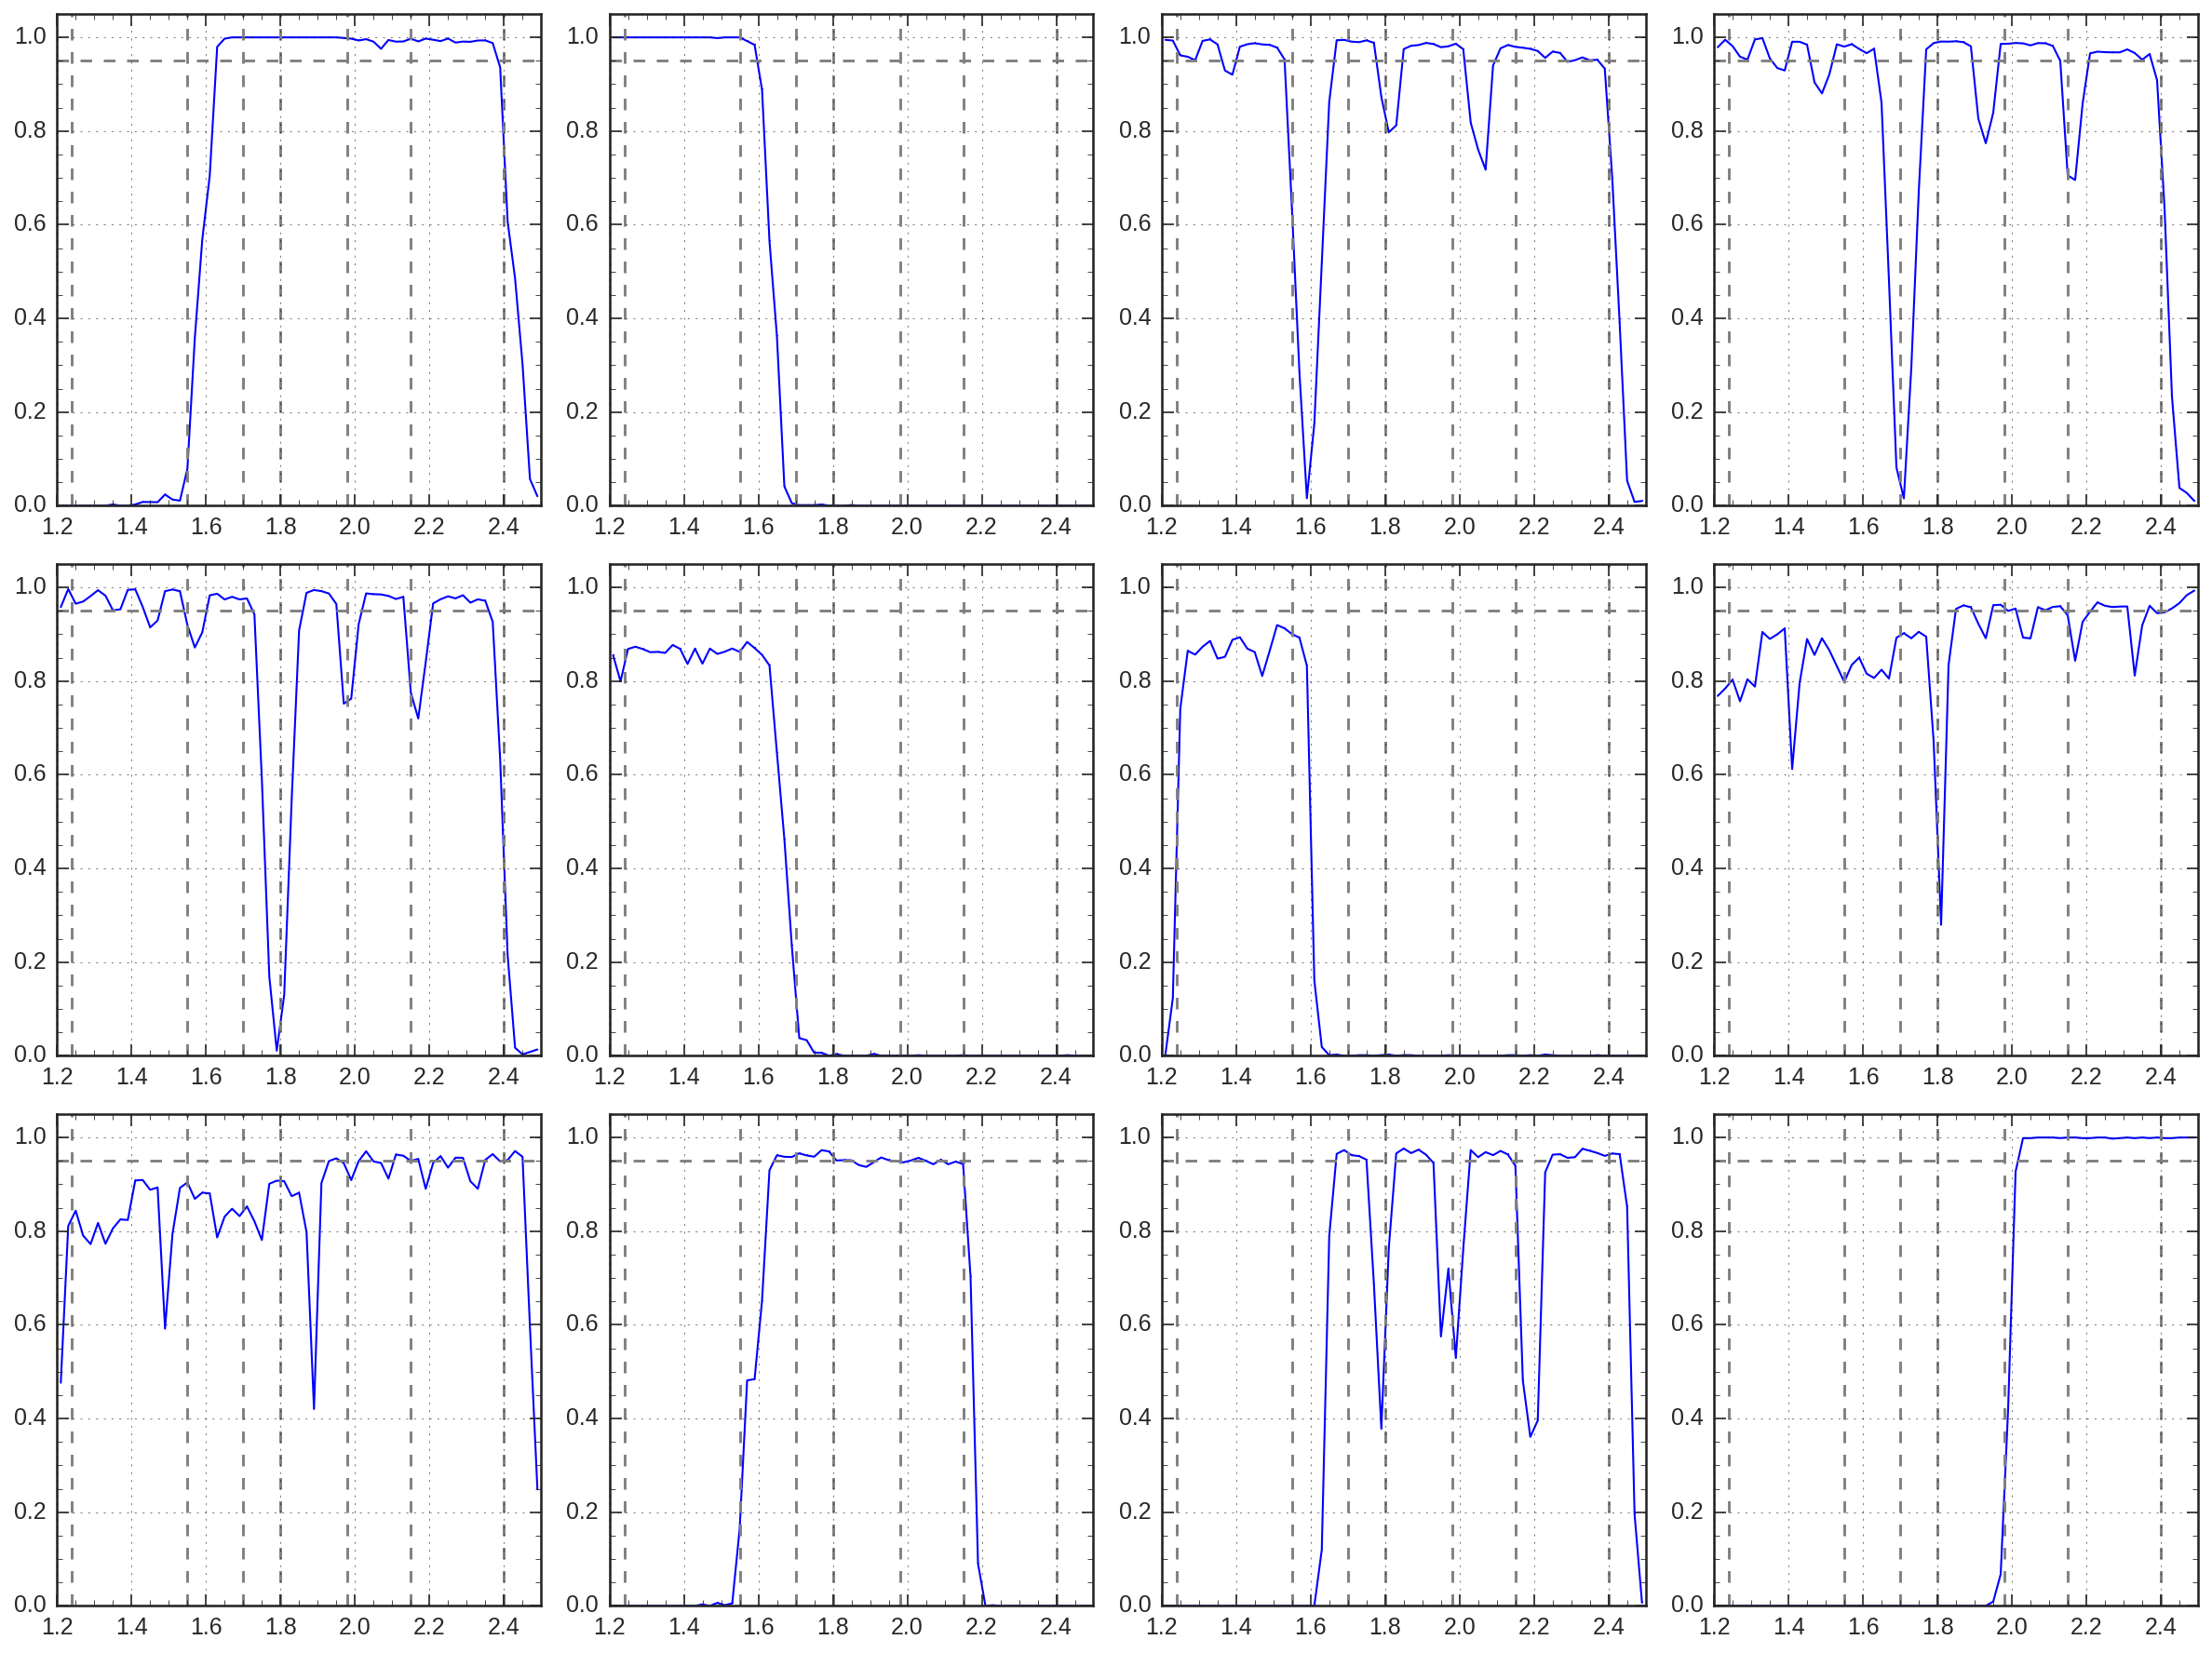

In [9]:
fig, axs = plt.subplots(12/4, 4, figsize=(4*4,4*12/4), tight_layout=True)

y_eta = out_part.copy()
x_mask = out_hits.copy().astype(np.bool)

for i in xrange(12):
  mask = x_mask[...,i]

  valid = ~mask  # valid hits

  denom_hist, edges = np.histogram(np.abs(y_eta), bins=70, range=(1.1,2.5))
  num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=70, range=(1.1,2.5))
  eff_hist = np.true_divide(num_hist, denom_hist)

  xdata = (edges[1:] + edges[:-1])/2
  ydata = eff_hist

  xmin, xmax = 1.2, 2.5
  ymin, ymax = 0, 1.05

  axs[i/4,i%4].errorbar(xdata, ydata, color='b', marker=',', capsize=0, lw=1)
  for x in [1.24, 1.55, 1.7, 1.8, 1.98, 2.15, 2.4]:  # vertical lines
    axs[i/4,i%4].plot([x,x], [ymin,ymax], '--', color='grey')
  for y in [0.95]:  # horizontal lines
    axs[i/4,i%4].plot([xmin,xmax], [y,y], '--', color='grey')
  axs[i/4,i%4].set_xlim(xmin,xmax)
  axs[i/4,i%4].set_ylim(ymin,ymax)

plt.show()